## NN-Body Experiments

In [1]:
%load_ext autoreload
%autoreload 2
from ipywidgets import *
%matplotlib inline
import tensorflow as tf
import numpy as np
import tqdm
import math
import matplotlib.pyplot as plt
from IPython import display
from matplotlib import animation, rc
from IPython.display import HTML
from simulation import nbody, RK4


from training import build_data_generator, build_data_queue, _flatten
from nnbody import NNBody

In [2]:
config = tf.ConfigProto(allow_soft_placement = True)
sess = tf.InteractiveSession(config = config)

### RK4 Test

In [78]:
n=10
PV = tf.placeholder(tf.float32, [n*2,2])
M = tf.placeholder(tf.float32, [n])
G = tf.constant(1.0)
nbody_dif_eq = nbody(M, G=G, eps_radius=1e-4)
t, pv = RK4(nbody_dif_eq, PV, 0.1, h=0.01)
sess.run(tf.initialize_all_variables())

100%|██████████| 9/9 [00:04<00:00,  2.19it/s]

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [55]:
# Initial conditions
mass = np.load("mass.npy")[:n]
P0V0 = (np.random.random((n*2,2)) - 0.5)*np.array([[1,1] if i < n else [0,0] for i in range(n*2)])

pv_hist = [P0V0]
tt = 20
for t in tqdm.tqdm(range(tt)):
    pv_hist += sess.run(pv[1:], {PV: pv_hist[-1], M: mass, G:0.000001})
pv_hist= np.array(pv_hist)

100%|██████████| 20/20 [00:00<00:00, 36.34it/s]


<IPython.core.display.Javascript object>


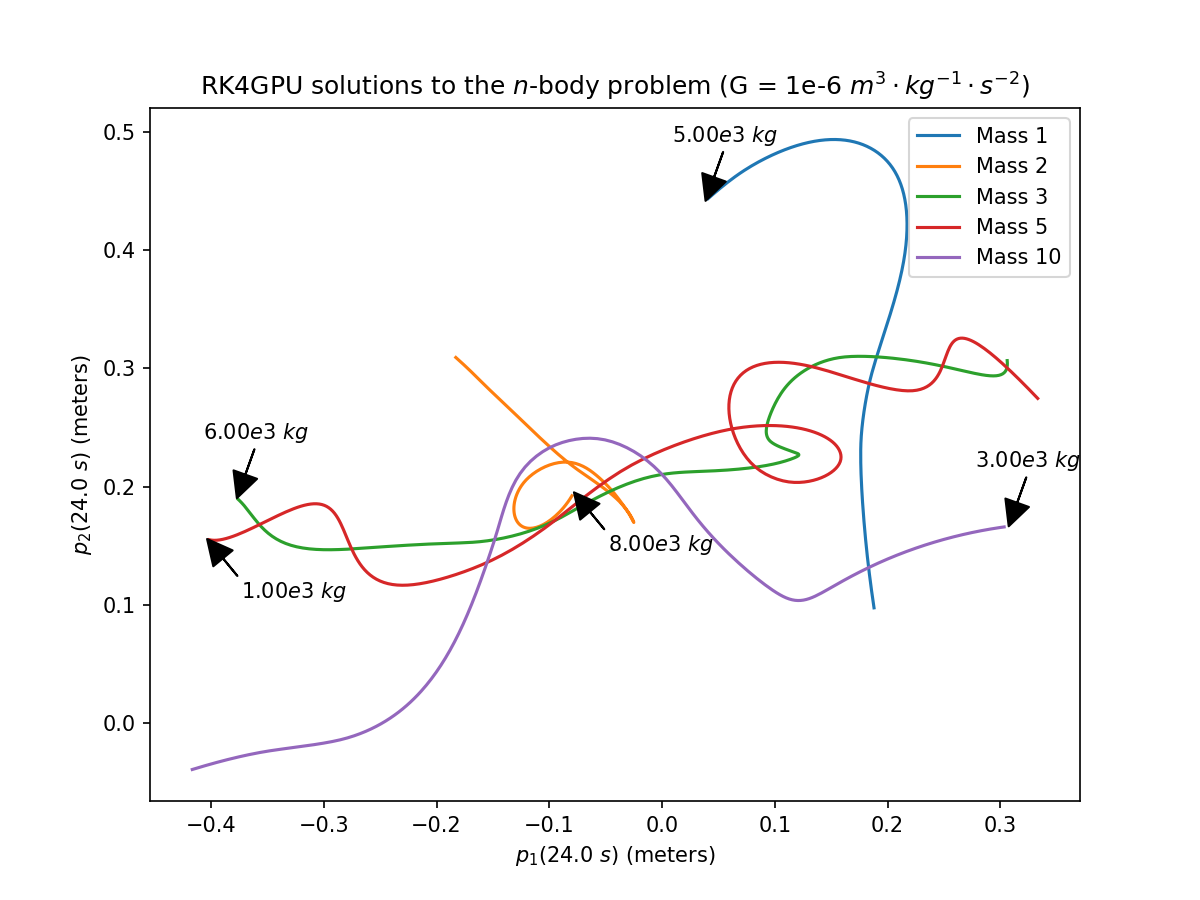

In [109]:
fig = plt.figure(figsize=(8,6))
def plot_solution(tmax=600*19):
    ax = plt.gca()
    skip = 1
    j = 0
    for i in range(10):
        if i in [5,3, 6, 7, 8]: continue
        j += 1
        plt.plot(pv_hist[:tmax:skip,i, 0],  pv_hist[:tmax:skip,i, 1], label="Mass {}".format(i+1))
        finalx, finaly = (pv_hist[tmax,i,0], pv_hist[tmax,i,1])
        ax.annotate('${:.2f}e3\ kg$'.format(mass[i]//1e3), xy=(finalx, finaly), xytext=(finalx-0.03*(-1)**(j+1), finaly +(-1)**(j+1)*0.05),
                arrowprops=dict(facecolor='black', shrink=0.001, width=0.01))
    plt.legend()
    plt.title("RK4GPU solutions to the $n$-body problem (G = 1e-6 $m^{3}\cdot kg^{−1}\cdot s^{−2}$)")
    plt.xlabel("$p_1(24.0\ s)$ (meters)")
    plt.ylabel("$p_2(24.0\ s)$ (meters)")

plot_solution(270)
#     plt.quiver(pv_hist[:tmax:skip,i, 0],  pv_hist[:tmax:skip,i, 1], 
#                pv_hist[:tmax:skip,i+3, 0],  pv_hist[:tmax:skip,i +3, 1], width=0.003)

# One-Shot Experiments.

<IPython.core.display.Javascript object>


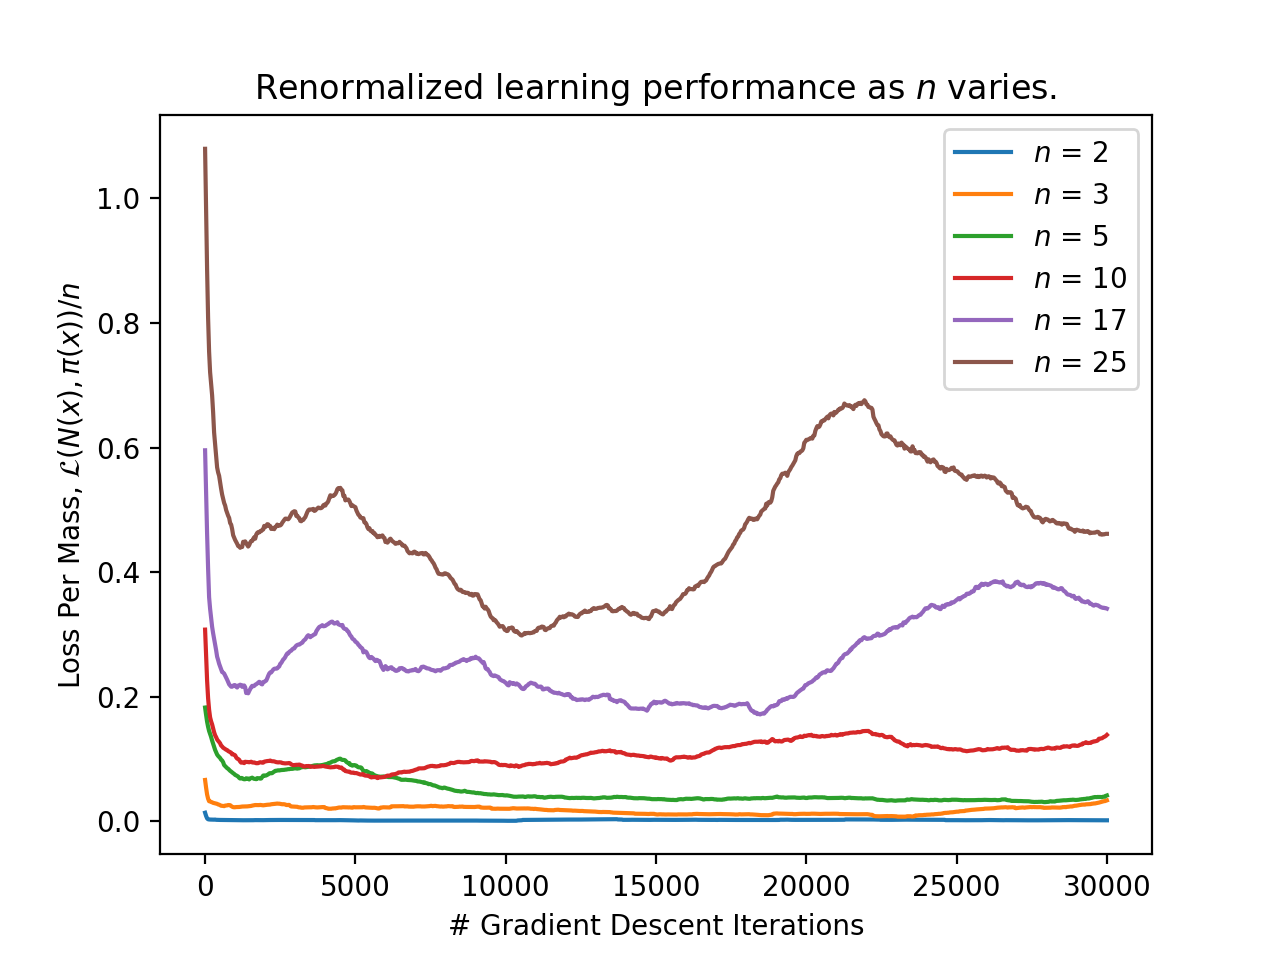

In [48]:
data = []
ntested =  [2,3,5,10,17,25]
N=100
for n in ntested:
    with open('../logs/run_{}body-logs,tag_NNBody-training-summaries-max-loss.csv'.format(n)) as f:
        lines = (line for line in f if not line.startswith('#'))
        FH = np.loadtxt(lines, delimiter=',', skiprows=1)
        smooth = np.convolve(FH[:,2], np.ones((N,))/N, mode='valid')
        data +=[smooth[0:30000]/n]
        

for dp, num in zip(data, ntested):
    xticks = np.linspace(0,30000, len(dp))
    plt.plot(xticks, dp, label="$n$ = {}".format(num))
 
plt.legend()
plt.xlabel("# Gradient Descent Iterations")
plt.ylabel("Loss Per Mass, $\mathcal{L}(N(x), \pi(x))/n$")
plt.title("Renormalized learning performance as $n$ varies.")
#plt.yscale("log")
    

## One-Shot Prediction Error vs Time

In [3]:
## Set up inital constants and data generators.
n = 10
H = 0.01 # RK4 step size
TMAX = 0.2 # Time max
mass = np.load("mass.npy")[:n]
(PV, M, G), (t, pv) = build_data_generator(sess, n)

# Simulate with neural network one-shot
data_queue, data_feed, dequeue = build_data_queue(
        n,
        1,
        1)

model = NNBody(sess, dequeue, data_queue, n)
model.initialize('/home/ec2-user/nnbody_exp/{}body/'.format(n), True)

100%|██████████| 19/19 [00:07<00:00,  2.50it/s]

INFO:tensorflow:Restoring parameters from /home/ec2-user/nnbody_exp/10body/model.cpkt


### RK4GPU Simulation

In [4]:
# Simulate using RK4
P0V0 = (np.random.random((n*2,2)) - 0.5)*np.array([[1,1] if i < n else [0,0] for i in range(n*2)])

# Get Simulation data
pv_hist = [P0V0]
tt = 20
for t in tqdm.tqdm(range(tt)):
    pv_hist += sess.run(pv[1:], {PV: pv_hist[-1], M: mass, G:0.000001})
pv_hist= np.array(pv_hist)

tint = np.linspace(0, TMAX*tt, math.ceil(tt*TMAX/H))

100%|██████████| 20/20 [00:00<00:00, 24.30it/s]


### One-Shot Neural Network Simulation

In [20]:
loss, pv_hist_oneshot = [],[[_flatten(P0V0)]]
for i, t in enumerate(tint):
    if i == len(pv_hist): break
    out, cur_loss = sess.run([model.output, model.loss], {
        dequeue[0]: np.expand_dims(np.concatenate([np.array([t*0.001]), _flatten(P0V0)]),0),
        dequeue[1]:  np.expand_dims(_flatten(pv_hist[i]),0)
    })
    pv_hist_oneshot+= [out]
    loss +=[ cur_loss]
    

for j in range(len(pv_hist_oneshot)):
    pv_hist_oneshot[j] = np.reshape(pv_hist_oneshot[j], [n*2,2])
 
pv_hist_oneshot = np.asarray(pv_hist_oneshot)

In [ ]:
fig=plt.Figure()
plt.plot(tint[:381], loss)
plt.title("Distance from true result to neural network.")
plt.ylabel("Loss")
plt.xlabel("Time (s)")

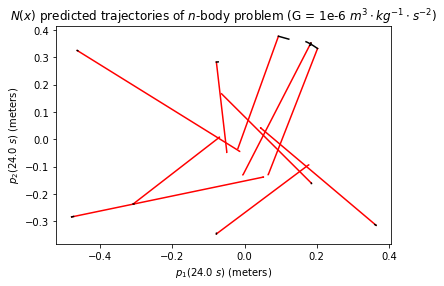

In [19]:
fig = plt.Figure()
def plot_solution(data, tmax, color, skip=1, s=1):
    ax = plt.gca()
    skip = 1
    j = 0
    for i in range(n):
        j += 1
        plt.plot(data[:tmax:skip,i, 0],  data[:tmax:skip,i, 1], label="Mass {}".format(i+1), color=color)
        finalx, finaly = (data[tmax,i,0], data[tmax,i,1])
#         ax.annotate('${:.2f}e3\ kg$'.format(mass[i]//1e3), xy=(finalx, finaly), xytext=(finalx-0.03*(-1)**(j+1), finaly +(-1)**(j+1)*0.05),
#                 arrowprops=dict(facecolor='black', shrink=0.001, width=0.01))
tot_time = 20
plot_solution(pv_hist_oneshot, tot_time, "red", skip=20)
plot_solution(pv_hist, tot_time, "black")
plt.title("$N(x)$ predicted trajectories of $n$-body problem (G = 1e-6 $m^{3}\cdot kg^{−1}\cdot s^{−2}$)")
plt.xlabel("$p_1(24.0\ s)$ (meters)")
plt.ylabel("$p_2(24.0\ s)$ (meters)")
#     plt.quiver(pv_hist[:tmax:skip,i, 0],  pv_hist[:tmax:skip,i, 1], 
#                pv_hist[:tmax:skip,i+3, 0],  pv_hist[:tmax:skip,i +3, 1], width=0.003)